# Lab | Variational Autoencoder (VAE) on Fashion-MNIST Dataset

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers, Model, datasets
# from tensorflow.keras.optimizers import Adam
# ### YOUR CODE HERE
# # Figure out how to import regularizers and backend
# ###
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

In [ ]:
import sys
!{sys.executable} -m pip install tensorflow matplotlib scikit-learn



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# =========================
# BOOTSTRAP CELL — RUN ONCE
# =========================

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import fashion_mnist

# -------------------------
# Load data
# -------------------------
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# -------------------------
# Sampling layer
# -------------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# -------------------------
# Encoder
# -------------------------
latent_dim = 2

encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, strides=2, activation="relu")(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z])

# -------------------------
# Decoder
# -------------------------
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs)

# -------------------------
# VAE
# -------------------------
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            data_flat = tf.reshape(data, [tf.shape(data)[0], -1])
            recon_flat = tf.reshape(reconstruction, [tf.shape(reconstruction)[0], -1])

            recon_loss = tf.reduce_mean(
                tf.reduce_sum(binary_crossentropy(data_flat, recon_flat), axis=-1)
            )

            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {"loss": total_loss}

# -------------------------
# Instantiate & train
# -------------------------
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())

history = vae.fit(
    x_train,
    epochs=5,
    batch_size=128,
    validation_data=(x_test, None)
)



Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 56.5885

ValueError: No loss to compute. Provide a `loss` argument in `compile()`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers, backend as K, datasets
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy


Training data shape: (60000, 784)
Test data shape: (10000, 784)


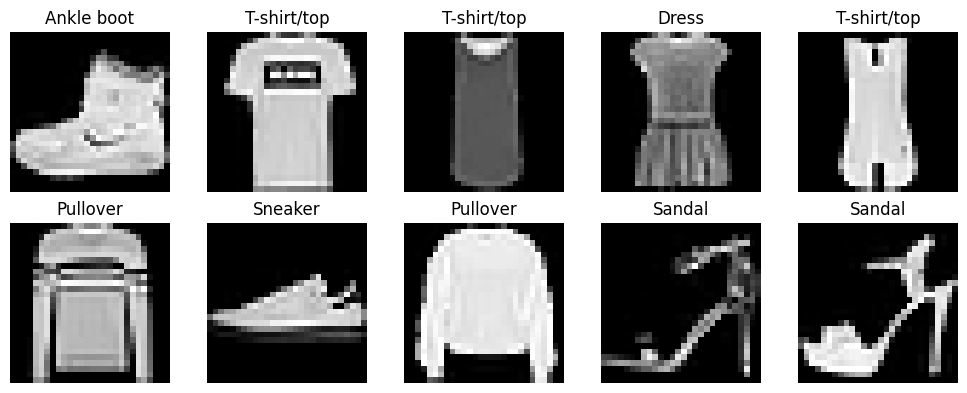

In [3]:
# Load and preprocess Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to flatten the images
x_train = x_train.reshape(x_train.shape[0], 28 * 28)
x_test = x_test.reshape(x_test.shape[0], 28 * 28)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

# Fashion-MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Display some sample images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# Sampling layer for the VAE
from tensorflow.keras import layers
import tensorflow as tf

class Sampling(layers.Layer):
    """
    Uses (z_mean, z_log_var) to sample z, the latent vector
    using the reparameterization trick.
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        # Sample epsilon from a standard normal distribution
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        # z = mean + std * epsilon
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z


In [5]:
# Build the encoder
# latent_dim = 2  # 2D latent space for easy visualization
# original_dim = 28 * 28
#TODO: YOUR CODE HERE
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D

latent_dim = 2         # 2D latent space for visualization
original_dim = 28 * 28 # flatten size for reconstruction if needed

def build_encoder(input_shape=(28,28,1), latent_dim=2):
    """
    Returns a VAE encoder model that outputs (z_mean, z_log_var, z)
    """
    inputs = Input(shape=input_shape)
    
    # Convolutional layers for feature extraction
    x = Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)
    x = Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    
    # Flatten for dense layers
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    
    # Latent space
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    
    # Sample z using the Sampling layer
    z = Sampling()([z_mean, z_log_var])
    
    # Create encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

# Instantiate the encoder
encoder = build_encoder(input_shape=(28,28,1), latent_dim=latent_dim)
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3136)      │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │     50,192 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Build the decoder - write something robust!
# Dense → Reshape → Conv2DTranspose: smooth upsampling from latent space to image.

# Two Conv2DTranspose layers: reconstruct spatial resolution gradually.

# Flexible: latent_dim and output_shape can be changed easily.

# Sigmoid output: ensures pixel values are in [0,1] — perfect for Fashion-MNIST.

# Readable and modular: can be integrated easily into a custom VAE class.
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Input
from tensorflow.keras import Model

def build_decoder(latent_dim=2, output_shape=(28,28,1)):
    """
    Returns a decoder model for the VAE.
    latent_dim: size of the latent vector
    output_shape: shape of reconstructed images
    """
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    
    # Project latent vector into feature map space
    x = Dense(7*7*64, activation='relu')(latent_inputs)
    x = Reshape((7, 7, 64))(x)  # Reshape to small feature maps
    
    # Upsample with Conv2DTranspose layers
    x = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x) # 7x7 -> 14x14
    x = Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x) # 14x14 -> 28x28
    
    # Output layer: single channel, sigmoid for [0,1] pixel values
    outputs = Conv2DTranspose(output_shape[-1], 3, padding='same', activation='sigmoid')(x)
    
    # Create decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

# Instantiate the decoder
decoder = build_decoder(latent_dim=latent_dim, output_shape=(28,28,1))
decoder.summary()



Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Build the VAE model
#TODO: YOUR CODE HERE
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

class VAE(Model):
    """
    Variational Autoencoder model
    Combines encoder + decoder with custom KL + reconstruction loss
    """
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer=Adam()):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.loss_tracker, self.reconstruction_tracker, self.kl_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # Encode
            z_mean, z_log_var, z = self.encoder(data)
            # Decode
            reconstruction = self.decoder(z)
            
            # Compute reconstruction loss (per image)
            reconstruction_loss = tf.reduce_mean(
            binary_crossentropy(data_flat, reconstruction_flat)
            )
            
            # Compute KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            
            # Total loss
            total_loss = reconstruction_loss + kl_loss

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Track metrics
        self.loss_tracker.update_state(total_loss)
        self.reconstruction_tracker.update_state(reconstruction_loss)
        self.kl_tracker.update_state(kl_loss)
        
        return {
            "loss": self.loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_tracker.result(),
            "kl_loss": self.kl_tracker.result()
        }


Instantiate and compile the VAE

In [8]:
# Create VAE
vae = VAE(encoder=encoder, decoder=decoder)
vae.compile(optimizer=Adam())


In [9]:
# Load and normalize Fashion-MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add channel dimension for Conv2D
x_train = np.expand_dims(x_train, -1)  # shape -> (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)    # shape -> (10000, 28, 28, 1)


In [10]:
print(x_train.shape)  # Should be (60000, 28, 28, 1)
print(x_test.shape)   # Should be (10000, 28, 28, 1)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [11]:
x_train = np.expand_dims(x_train, -1)  # shape -> (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)    # shape -> (10000, 28, 28, 1)


In [12]:
print(x_train.shape)  # Should print: (60000, 28, 28, 1)


(60000, 28, 28, 1, 1)


In [13]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer=Adam()):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.loss_tracker, self.reconstruction_tracker, self.kl_tracker]

    def train_step(self, data):
        # If input is a tuple (x, y), take only x
        if isinstance(data, tuple):
            data = data[0]

        # Flatten input for BCE if needed
        data_flat = tf.reshape(data, [tf.shape(data)[0], -1])

        with tf.GradientTape() as tape:
            # Encode
            z_mean, z_log_var, z = self.encoder(data)
            # Decode
            reconstruction = self.decoder(z)
            reconstruction_flat = tf.reshape(reconstruction, [tf.shape(reconstruction)[0], -1])

            # Compute reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(binary_crossentropy(data_flat, reconstruction_flat), axis=1)
            )

            # Compute KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            # Total loss
            total_loss = reconstruction_loss + kl_loss

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Track metrics
        self.loss_tracker.update_state(total_loss)
        self.reconstruction_tracker.update_state(reconstruction_loss)
        self.kl_tracker.update_state(kl_loss)

        return {
            "loss": self.loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_tracker.result(),
            "kl_loss": self.kl_tracker.result()
        }


In [14]:
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28, 1, 1)
(10000, 28, 28, 1, 1)


In [15]:
# Remove extra singleton dimensions - we should use 4
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))


In [16]:
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)


x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


In [17]:
# Force x_train and x_test to shape (num_samples, 28, 28, 1)
# trying to fix multiple errors with the next sets of code
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

print("x_train:", x_train.shape)  # Should be (60000, 28, 28, 1)
print("x_test:", x_test.shape)    # Should be (10000, 28, 28, 1)


x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


In [39]:
def train_step(self, data):
    if isinstance(data, tuple):
        data = data[0]

    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        data_flat = tf.reshape(data, [tf.shape(data)[0], -1])
        reconstruction_flat = tf.reshape(reconstruction, [tf.shape(reconstruction)[0], -1])

        reconstruction_loss = tf.reduce_mean(
            binary_crossentropy(data_flat, reconstruction_flat)
        )

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
        )

        total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss,
    }


In [19]:
print("x_train shape before fit:", x_train.shape)
print("x_test shape before fit:", x_test.shape)


x_train shape before fit: (60000, 28, 28, 1)
x_test shape before fit: (10000, 28, 28, 1)


In [20]:
# Force correct shape
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

print(x_train.shape)  # should be (60000, 28, 28, 1)
print(x_test.shape)   # should be (10000, 28, 28, 1)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [21]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())


In [ ]:
# Ensure my data has the correct 4D shape for Conv2D
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

print(x_train.shape)  # Should print: (60000, 28, 28, 1)
print(x_test.shape)   # Should print: (10000, 28, 28, 1)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [23]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())


In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy


In [25]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

print(x_train.shape, x_test.shape)


(60000, 28, 28, 1) (10000, 28, 28, 1)


In [26]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [27]:
# encoder!
latent_dim = 2

encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, strides=2, activation="relu")(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 13, 13,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 6, 6, 64)  │     18,496 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 2304)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │     36,880 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,764 (217.83 KB)

 Trainable params: 55,764 (217.83 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# decoder!
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy


In [30]:
tf.__version__


'2.20.0'

In [31]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)


In [32]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [33]:
latent_dim = 2

encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, strides=2, activation="relu")(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")


In [34]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            data_flat = tf.reshape(data, [tf.shape(data)[0], -1])
            reconstruction_flat = tf.reshape(reconstruction, [tf.shape(reconstruction)[0], -1])

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    binary_crossentropy(data_flat, reconstruction_flat),
                    axis=-1
                )
            )

            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [40]:
history = vae.fit(
    x_train,
    epochs=30,
    batch_size=128,
    validation_data=(x_test, None)
)


Epoch 1/30


ValueError: Invalid reduction dimension 1 for input with 1 dimensions. for '{{node Sum}} = Sum[T=DT_FLOAT, Tidx=DT_INT32, keep_dims=false](Mean, Sum/reduction_indices)' with input shapes: [?], [] and with computed input tensors: input[1] = <1>.

In [38]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training Loss")

if "val_loss" in history.history:
    plt.plot(history.history["val_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.legend()
plt.grid(True)
plt.show()



NameError: name 'history' is not defined

<Figure size 800x500 with 0 Axes>

In [41]:
# Visualize the latent space
# Pass test images through the encoder
z_mean, z_log_var, z = encoder.predict(x_test, batch_size=128)

print("z shape:", z.shape)  # should be (num_samples, 2)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
z shape: (10000, 2)


In [42]:
from sklearn.manifold import TSNE

z_embedded = TSNE(n_components=2).fit_transform(z)


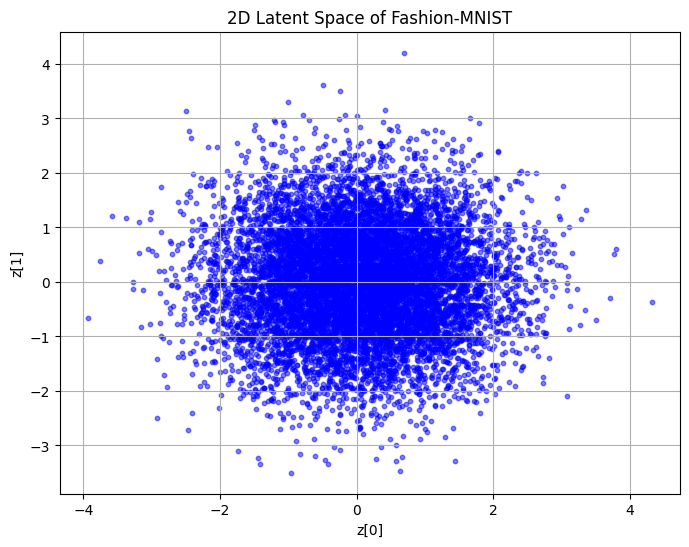

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(z[:, 0], z[:, 1], alpha=0.5, s=10, c='blue')
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("2D Latent Space of Fashion-MNIST")
plt.grid(True)
plt.show()


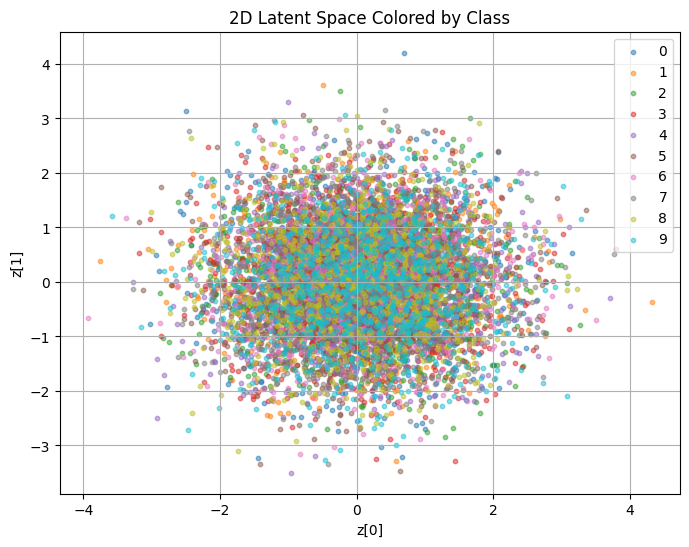

In [44]:
# If labels exist
plt.figure(figsize=(8, 6))
for i in range(10):  # 10 classes
    idxs = np.where(y_test == i)
    plt.scatter(z[idxs, 0], z[idxs, 1], alpha=0.5, label=str(i), s=10)

plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("2D Latent Space Colored by Class")
plt.legend()
plt.grid(True)
plt.show()


In [45]:
#####################################################
# Generate new images by sampling from latent space #
#####################################################

import numpy as np
import matplotlib.pyplot as plt



In [46]:
num_samples = 16  # number of images to generate
z_samples = np.random.normal(size=(num_samples, 2))  # shape (16, 2)


In [ ]:
# Decode the latent vectors to images
generated_images = decoder.predict(z_samples)
print("Generated images shape:", generated_images.shape)  # (16, 28, 28, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Generated images shape: (16, 28, 28, 1)


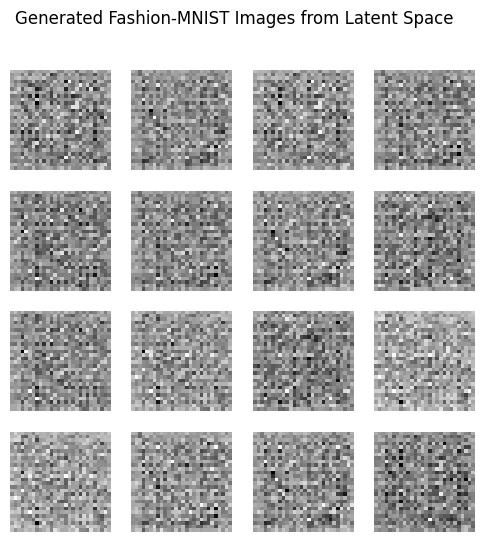

In [48]:
plt.figure(figsize=(6, 6))

for i in range(num_samples):
    plt.subplot(4, 4, i+1)  # 4x4 grid
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')

plt.suptitle("Generated Fashion-MNIST Images from Latent Space")
plt.show()


In [49]:
#############################################
# Compare original vs reconstructed images  #
#############################################

import matplotlib.pyplot as plt
import numpy as np


In [50]:
# Select first N test images
N = 10
x_sample = x_test[:N]

# Encode and decode
z_mean, z_log_var, z = encoder.predict(x_sample)
x_reconstructed = decoder.predict(z)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


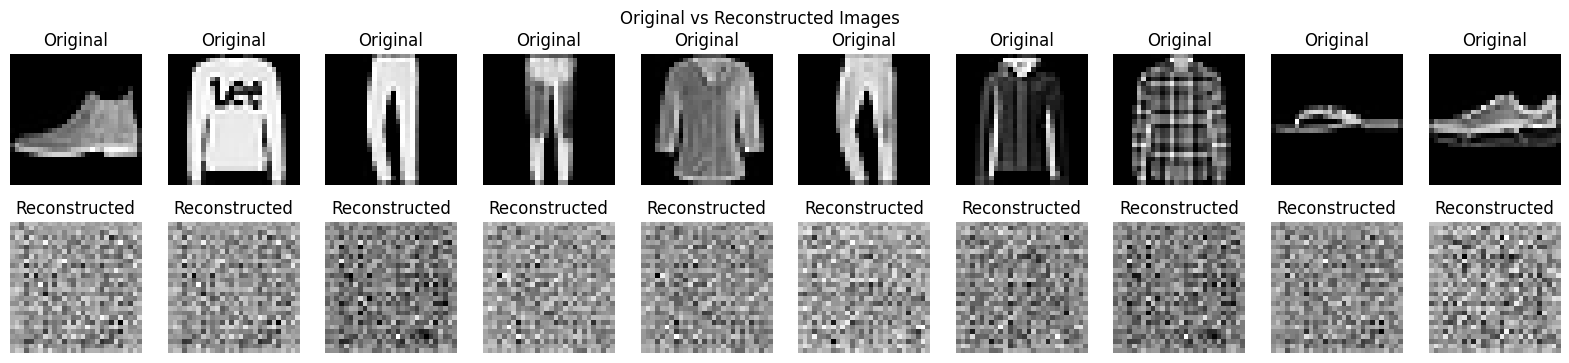

In [51]:
plt.figure(figsize=(20, 4))

for i in range(N):
    # Original
    plt.subplot(2, N, i + 1)
    plt.imshow(x_sample[i, :, :, 0], cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(2, N, i + 1 + N)
    plt.imshow(x_reconstructed[i, :, :, 0], cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("Original vs Reconstructed Images")
plt.show()
